In [1]:
import sys
sys.path.append('../')

import yfinance as yf
import datetime
from data_collection import utils
utils.create_path('datasets')
import torch
import time_series_utils as sp
from models import LSTMModel, GRUModel
import pandas as pd

## Getting the data

In [2]:
# Get the current date and time
now = datetime.datetime.now()
# Define the start date
start_date = datetime.datetime(2009, 1, 1)
# Get the Bitcoin data from Yahoo Finance
df = yf.download('BTC-USD', start=start_date, end=now)
df.to_csv('datasets/bitcoin.csv')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-28,57071.097656,63913.132812,56738.425781,62504.789062,62504.789062,83239156760
2024-02-29,62499.183594,63585.644531,60498.730469,61198.382812,61198.382812,65496611844
2024-03-01,61168.062500,63155.101562,60802.527344,62440.632812,62440.632812,40186368423


## Exploring the dataset

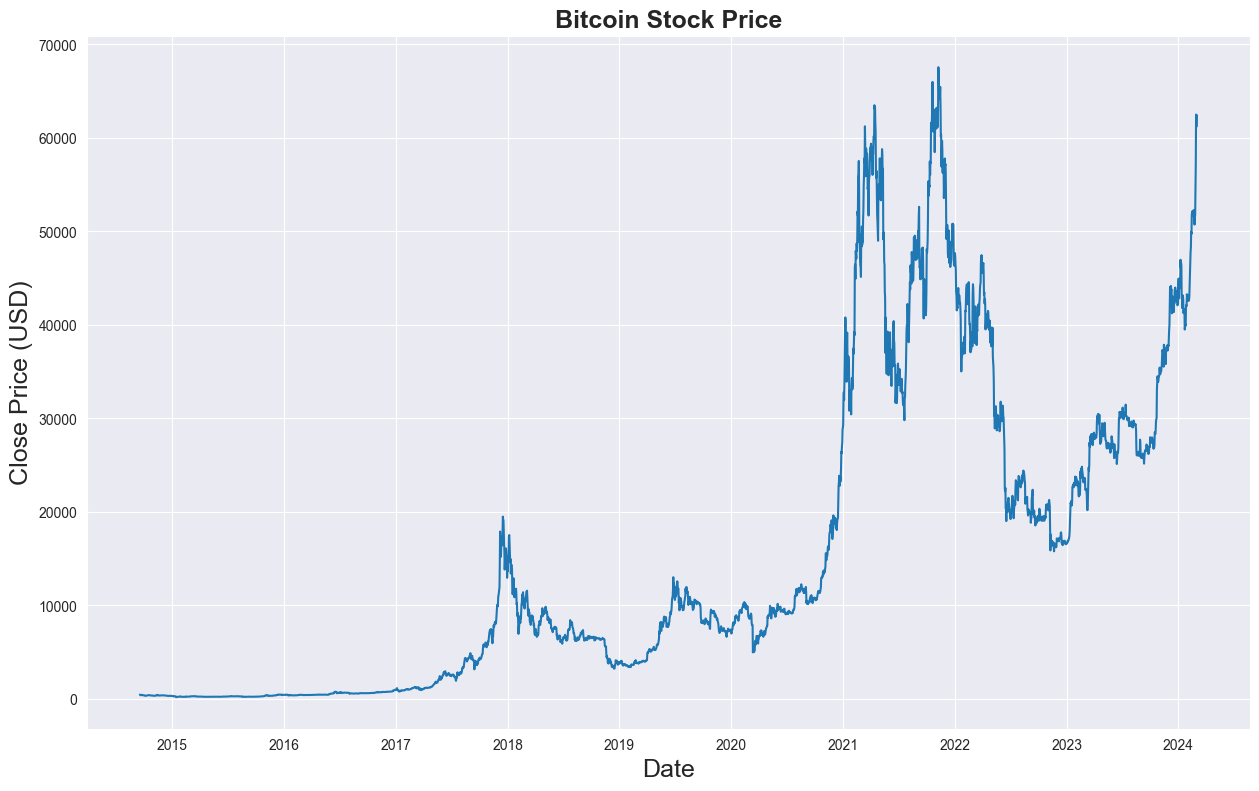

In [4]:
sp.plot_stock_price(df)

## Normalizing the data on Adjust Close price and splitting the data

We will use "Adjusted Close" to remove any artificial price turbulences due to stock splits and dividend payout events. It is generally considered an industry best practice to use split/dividend-adjusted prices instead of raw prices to model stock price movements.

In [5]:
normalized_data_close_price, scaler = sp.normalize_data(df)
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = sp.split_data(normalized_data_close_price, lookback)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2747, 20, 1) (2747, 1) (687, 20, 1) (687, 1)


## Moving the data into torch

In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

## Training the model

In [7]:
model = sp.define_model(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2, model_type='LSTM')

learning_rate=0.01
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list, model, y_train_pred = sp.train_model(model, x_train, y_train_lstm, criterion, optimiser, num_epochs=100)

c:\Users\sinaz\.conda\envs\sina\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0, Loss: 0.064060740172863
Epoch: 10, Loss: 0.0011004679836332798
Epoch: 20, Loss: 0.0019621076062321663
Epoch: 30, Loss: 0.0013870821567252278
Epoch: 40, Loss: 0.0006982216727919877
Epoch: 50, Loss: 0.000625676941126585
Epoch: 60, Loss: 0.000502382346894592
Epoch: 70, Loss: 0.00041694100946187973
Epoch: 80, Loss: 0.00035644732997752726
Epoch: 90, Loss: 0.00031514849979430437
Training time: 5.657228946685791


In [8]:
predict_train_y = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original_train_y = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

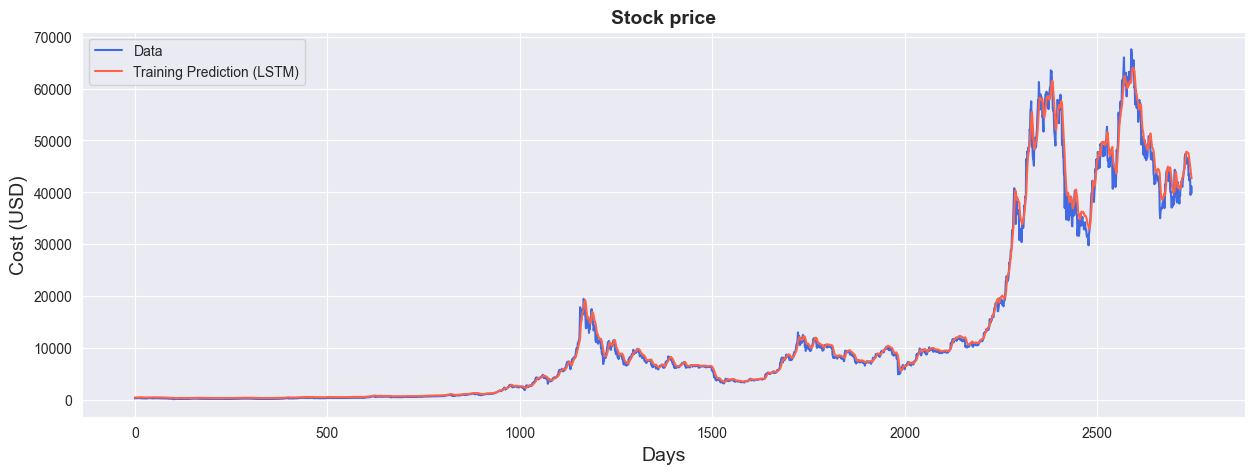

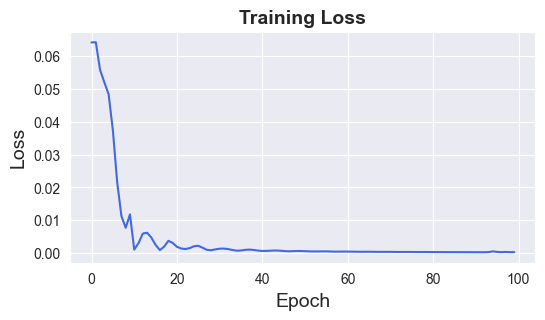

In [9]:
sp.plot_training_results(original_train_y, predict_train_y, loss_list)

## Predict the data in the test dataset and compute score

In [10]:
predict_test_y, original_test_y = sp.test_model(model, x_test, y_test_lstm, scaler)

Test Score: 1898.58 RMSE


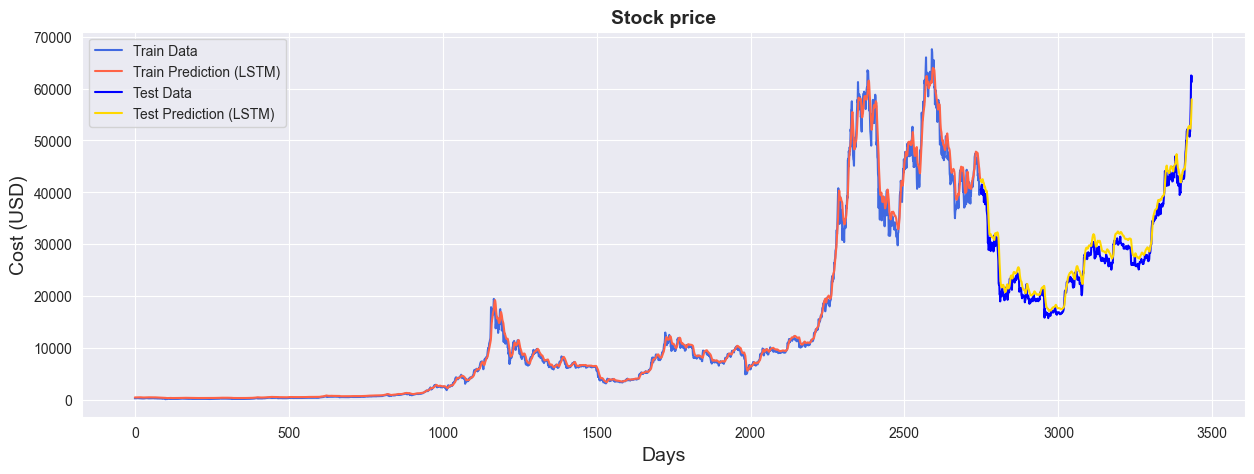

In [11]:
sp.plot_all_results(original_train_y, predict_train_y, original_test_y, predict_test_y)


## Predict the next day

In [12]:
result = sp.predict_next_day(model, x_test, scaler)
print(result)

57928.7109375


## Predict 10 days in the future

In [13]:
predictions = sp.predict_next_n_days(model, x_test, scaler, 10)
print(predictions)

[[ 57928.71 ]
 [103340.88 ]
 [122563.61 ]
 [130234.914]
 [133618.28 ]
 [135305.97 ]
 [136226.97 ]
 [136764.17 ]
 [137095.   ]
 [137309.48 ]]


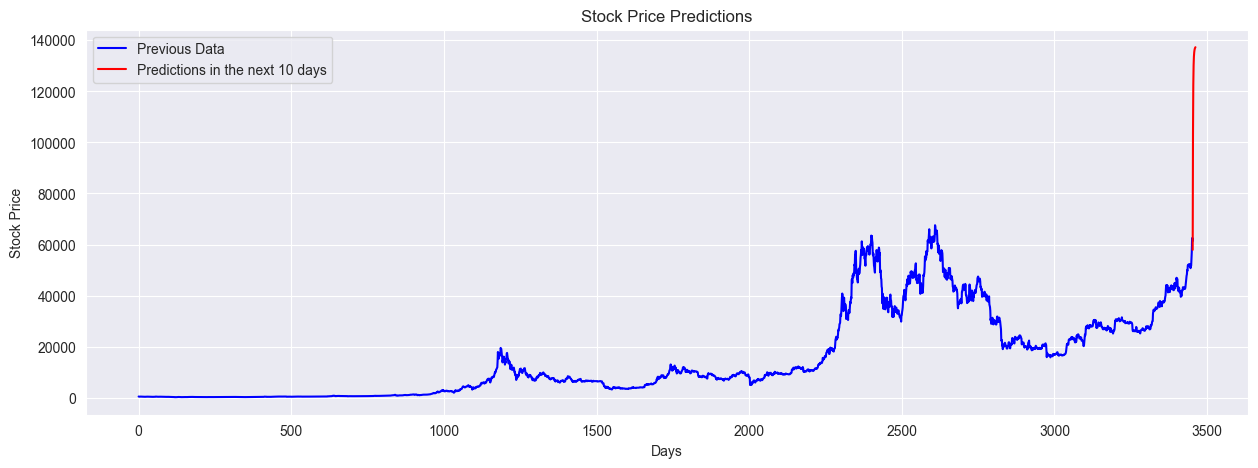

In [14]:
sp.plot_future_predictions(df, predictions)

In [15]:
utils.create_path('saved_models')
torch.save(model.state_dict(), 'saved_models/lstm_model.pth')